In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import numpy as np 
from numpy import abs as Abs
from numpy import sign as sign

from control.matlab import *  # MATLAB-like functions
import control as ct
from scipy import signal
 
 
import matplotlib
import matplotlib.pyplot as plt
 
import tensorflow as tf
from gym import Env
from gym.spaces import Discrete, Box
 
import random
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [3]:
# Quarter car model
M = 600  # Body mass (in Kg)
m = 75  # Mass of tyre (in Kg)
Ks = 30  # Spring constant
Kt = 300  # Spring constant of wheel
Cs = 400  # Damping coefficient
n = 2  # DOF
r = 1  # No of Actuator

# MR Damper
V = 20
K1 = 542.18
K2 = 550.16
C1 = 999.4
C2 = 3387.5
alpha  = 3846.2 
beta = 126.84
gamma = 303.83 
A1 = 96.067
N = 3

# State space representation (states - y1, y2, dot(y1), dot(y2)) 
# Continous time
A =np.array([[0 ,0 ,1 ,0 ],
              [0 ,0 ,0 ,1 ],
              [-Ks/M, Ks/M, 0, 0],
              [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
# Input matrix (Control force and Earthquake input)
B  = np.array([[0,0,1/M,-1/m]]).T
# Influence vector (Earthquake input)
E = np.array([[0,0,0,Kt/m]]).T 
# Output matrix (Disp + Accel)
Cd = np.array([[1, 1, 0, 0], [-Ks/M, Ks/M, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
Dd = np.array([[0, 1/M, -1/m]]).T
Ed = np.array([[0, 0, 0]]).T

[[ 2988.42995439]
 [10451.11295745]
 [ 3055.611805  ]
 [ 6504.21876359]
 [ 4030.59083917]
 [ 1072.71283895]] [[ 964.34181395]
 [2026.04508468]
 [ 932.38259073]
 [1454.13623603]
 [ 833.6819041 ]
 [ 625.55714392]]


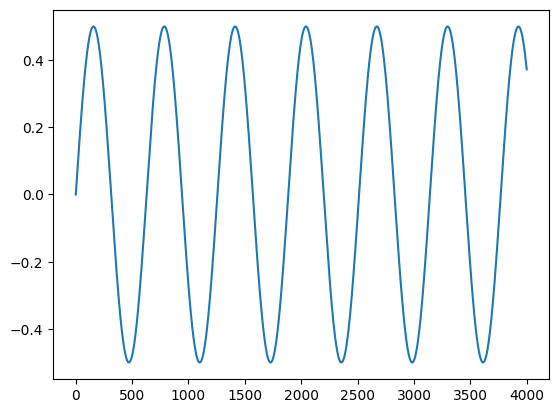

In [4]:
# Input Sinusoid
T = 40
dt = 0.01
t = np.arange(0, T+dt, dt)
omega1 = 1
omega2 = 0
amplitude   = 0.5*(np.sin(omega1*t) + np.sin(omega2*t))
plt.plot(amplitude)

Qp = np.array([[Ks, -Ks, 0, 0],
               [-Ks, Ks+Kt, 0, 0],
               [0, 0, M, 0],
               [0, 0, 0, m]])
# print(Qp)
(i,j)=B.shape
Rp =  (10**(0))*np.identity(j)
Kp1, Sp1, ep1 = ct.lqr(A, B, Qp, Rp)
del i, j

T = 50
dt = 0.01

nt = len(t)
x_uc = np.zeros([nt, 2*n, 6])
y_uc = np.zeros([nt, n, 6])
x_c = np.zeros([nt, 2*n, 6])
y_c = np.zeros([nt, n, 6])
J1_val = np.zeros([6, 1])
J2_val = np.zeros([6, 1])
U = np.zeros([nt, 6])

Fs = 100      # Sampling rate (Hz)
T = 40        # Duration (seconds)
dt = 0.01
# Generate a random signal with a mean of 0 and standard deviation of 1
t = np.arange(0, T+dt, dt)
# Input Sinusoid (Resonant Frequencies)
k = 0
for i in range(1, 3):
    for j in range(0, 3):
        omega1 = i
        omega2 = j/10
        x = np.random.normal(0, 1, size=len(t))

        # Define the filter parameters
        fc = 3       # Cutoff frequency (Hz)
        order = 4    # Filter order

        # Design the Butterworth filter
        nyquist_rate = 0.5 * 1/dt
        cutoff_freq = fc / nyquist_rate
        b, a = butter(order, cutoff_freq, 'low')

        # Apply the filter to the signal
        y = filtfilt(b, a, x)
        amplitude = y
        
        # Openloop
        sys_uc = signal.StateSpace(A, E, Cd, np.array([[0, 0, 0]]).T)
        t1,y1,x1 = signal.lsim(sys_uc,amplitude,t)
        x_uc[:, :, k] = x1
        y_uc[:, :, k] = y1[:, 1:3]
        del t1, y1, x1

        sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, np.array([[0, 0, 0]]).T)
        t2,y2,x2 = signal.lsim(sys_c,amplitude,t)
        x_c[:, :, k] = x2
        y_c[:, :, k] = y2[:, 1:3]
        del t2, y2, x2
        k = k+1
del i, j, k
for k in range(0, 6):
    for tkk in range(0,len(t)):
        U[tkk, k] = Kp1@x_uc[tkk,:,k].T
        En1 = 0.5*((x_uc[tkk,:,k]@Qp)@x_uc[tkk,:,k].T)
        En2 = 0.5*((x_c[tkk,:,k]@Qp)@x_c[tkk,:,k].T)
        J1 = dt*En1
        J2 = dt*En2
        J1_val[k] += J1 
        J2_val[k] += J2
print(J1_val, J2_val)

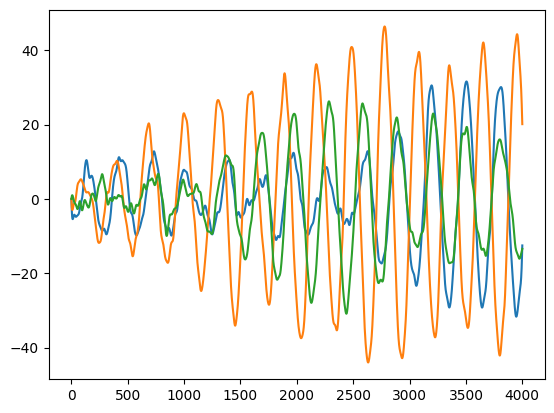

In [5]:
plt.plot(U[:, 0:3])

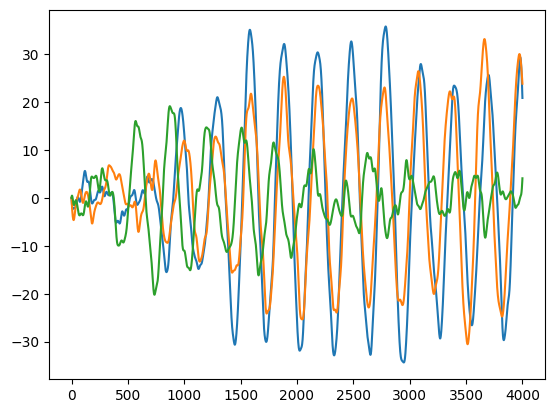

In [6]:
 plt.plot(U[:, 3:6])

In [7]:
class MrDamperEnv(Env):

    def __init__(self):
      self.Ad = 0.45 
      self.V = 20
      self.M = 600
      self.m = 75
      self.Ks = 30
      self.Cs = 400
      self.Kt = 300
      self.K1 = 542.18
      self.K2 = 550.16
      self.C1  =999.4 
      self.C2  = 3387.5 
      self.A1 = 96.067
      self.N = 3
      self.values =  [[],[],[],[]] 
      self.action = np.array([])
      self.chooser = np.random.randint(low=1,high=5)
      #self.file = "la"+"%02d" % self.chooser + ".dat"     #la45
      #self.amplitude   = 0.1*np.array(np.loadtxt(self.file)).flatten()
    # Input Road Profile (Trial input)
      self.T = 40
      self.dt = 0.01
      self.t = np.arange(0, self.T+self.dt, self.dt)
      #self.omega1 = np.random.randint(low=1,high=3)
      #self.omega2 = np.random.randint(low=0,high=3)
      self.x_uf = np.random.normal(0, 1, size=len(self.t))
      self.fc = 3       # Cutoff frequency (Hz)
      self.order = 4    # Filter order

        # Design the Butterworth filter
      self.nyquist_rate = 0.5 * 1/self.dt
      self.cutoff_freq = self.fc / self.nyquist_rate
      self.b, self.a = butter(self.order, self.cutoff_freq, 'low')
      self.amplitude = filtfilt(self.b, self.a, self.x_uf)
      self.state = np.array([[0,0,0,0]]) #y1,y1dot,y1dotdot,y2,y2dot
      #dt =??
      #self.t = np.arange(0, self.T+self.dt, self.dt)
      
      self.time_current =  0
      self.E = 0 
      self.J = 0
      self.en = []
      self.hr = []
      self.J_val = 0
      self.action_space = Box(low=-100, high=100,shape=(1,)) 
      self.observation_space = Box(low=np.array([-100000,-100000,-100000,-100000, -100000,-100000]), high=np.array([100000,100000,100000,100000, -100000,-100000]) )
      self.statem = np.array([0,0,0,0])
      self.stateh = np.array([0,0,0,0,0,0])

    def step(self, action): 
           
          U = action
          self.en.append(U)
          Ad = self.Ad 
          V = self.V 
          M = self.M 
          m = self.m 
          Ks = self.Ks 
          Cs = self.Cs 
          Kt = self.Kt 
          K1 = self.K1
          K2 = self.K2 
          C1 = self.C1 
          C2 = self.C2 
          self.J = 0
          xns =  np.array([[0,0,0,0]])
          #f1 = []
          z =  20+self.time_current
          A1 = self.A1
          N = self.N
          self.rewardlist = np.array([])
          self.action = np.append(self.action,action) 
          dt = self.dt
          i = 0
          for tkk in range(self.time_current,z):
            h = self.amplitude[tkk] 
            self.hr.append(h)
            xn = np.array([[self.state[0][0], self.state[0][1], self.state[0][2], self.state[0][3]]]).T
            A = np.array([[0 ,0 ,1 ,0 ],
                        [0 ,0 ,0 ,1 ],
                        [-self.Ks/self.M, self.Ks/self.M, 0, 0],
                        [self.Ks/self.m, -1*(self.Ks+self.Kt)/self.m, 0, 0]])
            Bu  = U*np.array([[0,0,1/self.M,-1/self.m]]).T
            f = h*((np.array([[0,0,0,self.Kt/self.m]])).transpose()) 
            D = f + Bu
            k1 = self.dt*((A)@xn + D)
            k2 = self.dt*(A@(xn + 0.5*k1)+ D)
            k3 = self.dt*(A@(xn + 0.5*k2)+ D)
            k4 = self.dt*(A@(xn + k3)+ D)
            xn1 = xn + (k1 + 2*k2 + 2*k3 + k4)/6
            xn11 = np.array([[xn1[0][0],xn1[1][0],xn1[2][0],xn1[3][0]]])
            #f1.append(xn1[0][0])  
            self.state = xn11
            Q = np.array([[Ks, -Ks, 0, 0],
                  [-Ks, Ks+Kt, 0, 0],
                  [0, 0, M, 0],
                  [0, 0, 0, m]])
            
            self.E = 0.5*((xn11@Q)@xn11.T) 
            #print(self.E)
            self.J = self.J + dt*(0.9**i)*(self.E[0][0])
            if(i==0):
              
              self.statem = np.array([xn1[0][0],xn1[1][0],xn1[2][0],xn1[3][0]])
              self.stateh = np.array([xn1[0][0],xn1[1][0],xn1[2][0],xn1[3][0],h,np.squeeze(U)])
              xns = np.array([[xn1[0][0],xn1[1][0],xn1[2][0],xn1[3][0]]])
              self.J_val += self.J 
            i = i+1
          #print("kkk ",self.J_val)
          #print(self.J) 
          done = False
          #print(f1)
          info = {}   
          reward = -1*self.J
          self.state = xns
          self.values[0].append(self.statem[0])  
          self.values[1].append(self.statem[1])
          self.values[2].append(self.statem[2])
          self.values[3].append(self.statem[3])
          return self.stateh, reward, done, info

    def reset(self):
      self.Ad = 0.45 
      self.V = 20
      self.M = 600
      self.m = 75
      self.Ks = 30
      self.Cs = 400
      self.Kt = 300
      self.K1 = 542.18
      self.K2 = 550.16
      self.C1  =999.4 
      self.C2  = 3387.5 
      self.A1 = 96.067
      self.N = 3
      self.values =  [[],[],[],[]] 
      self.action = np.array([])
      self.chooser = np.random.randint(low=1,high=5)
      #self.file = "la"+"%02d" % self.chooser + ".dat"     #la45
      #self.amplitude   = 0.1*np.array(np.loadtxt(self.file)).flatten()
    # Input Road Profile (Trial input)
      self.T = 40
      self.dt = 0.01
      self.t = np.arange(0, self.T+self.dt, self.dt)
      #self.omega1 = np.random.randint(low=1,high=3)
      #self.omega2 = np.random.randint(low=0,high=3)
      self.x_uf = np.random.normal(0, 1, size=len(self.t))
      self.fc = 3       # Cutoff frequency (Hz)
      self.order = 4    # Filter order

      # Design the Butterworth filter
      self.nyquist_rate = 0.5 * 1/self.dt
      self.cutoff_freq = self.fc / self.nyquist_rate
      self.b, self.a = butter(self.order, self.cutoff_freq, 'low')
      self.amplitude = filtfilt(self.b, self.a, self.x_uf)
      self.state = np.array([[0,0,0,0]]) #y1,y1dot,y1dotdot,y2,y2dot
      #dt =??
      #self.t = np.arange(0, self.T+self.dt, self.dt)
      self.time_current =  0  
      self.E = 0 
      self.J = 0
      self.en = []
      self.hr = []
      self.J_val = 0
      self.action_space = Box(low=-100, high=100,shape=(1,)) 
      self.observation_space = Box(low=np.array([-100000,-100000,-100000,-100000,-100000,-100000]), high=np.array([100000,100000,100000,100000, -100000,-100000 ]) )
      self.statem = np.array([0,0,0,0])
      self.stateh = np.array([0,0,0,0,0,0])
      A =np.array([[0 ,0 ,1 ,0 ],
                   [0 ,0 ,0 ,1 ],
                   [-Ks/M, Ks/M, 0, 0],
                   [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
      # Input matrix (Control force and Earthquake input)
      B  = np.array([[0,0,1/M,-1/m]]).T
      # Influence vector (Earthquake input)
      E = np.array([[0,0,0,Kt/m]]).T
      # Output matrix (Disp + Accel)
      Cd = np.array([[1, 1, 0, 0], [-Ks/M, Ks/M, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
      Dd = np.array([[0, 1/M, -1/m]]).T
      Ed = np.array([[0, 0, 0]]).T
      x_uc = np.zeros([len(self.t), 2*n])
      y_uc = np.zeros([len(self.t), n])
      x_c = np.zeros([len(self.t), 2*n])
      y_c = np.zeros([len(self.t), n])
      J1_val = np.zeros([1, 1])
      J2_val = np.zeros([1, 1])
      U = np.zeros([len(self.t), 1])
      # Openloop
      sys_uc = signal.StateSpace(A, E, Cd, Ed)
      t1,y1,x1 = signal.lsim(sys_uc,self.amplitude,self.t)
      x_uc[:, :] = x1
      y_uc[:, :] = y1[:, 1:3]
      del t1, y1, x1
      # LQR
      Qp = np.array([[Ks, -Ks, 0, 0],
                     [-Ks, Ks+Kt, 0, 0],
                     [0, 0, M, 0],
                     [0, 0, 0, m]])
      # print(Qp)
      (i,j)=B.shape
      Rp =  (10**(0))*np.identity(j)
      Kp1, Sp1, ep1 = ct.lqr(A, B, Qp, Rp)
      del i, j

      sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, Ed)
      t2,y2,x2 = signal.lsim(sys_c,self.amplitude,self.t)
      x_c[:, :] = x2
      y_c[:, :] = y2[:, 1:3]
      del t2, y2, x2

      for tkk in range(0,len(self.t)):
            U[tkk, :] = Kp1@x_uc[tkk,:].T
            En1 = 0.5*((x_uc[tkk,:]@Qp)@x_uc[tkk,:].T)
            En2 = 0.5*((x_c[tkk,:]@Qp)@x_c[tkk,:].T)
            J1 = self.dt*En1
            J2 = self.dt*En2
            J1_val[:,:] += J1
            J2_val[:,:] += J2
      print(J1_val, J2_val)
      del A, B, Kp1, Cd, Dd, Ed, Qp, Rp, tkk
      return self.stateh


env = MrDamperEnv()

states = env.observation_space.shape
actions = env.action_space

C:\Users\91735\anaconda3\envs\tf-gpu-new\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [8]:
states = env.observation_space.shape
num_states = states[0]
print("Size of State Space ->  {}".format(num_states))
actions = env.action_space.shape
num_actions = actions[0]
print("Size of Action Space ->  {}".format(num_actions))
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  6
Size of Action Space ->  1
Max Value of Action ->  100.0
Min Value of Action ->  -100.0


In [9]:
env.action_space.sample()

array([-29.594131], dtype=float32)

In [10]:
env.observation_space.sample()

array([  68801.375 ,  -11765.5205,  -75942.89  ,   20371.494 ,
       -100000.    , -100000.    ], dtype=float32)

In [11]:
 class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = ( self.x_prev+ self.theta * (self.mean - self.x_prev) * self.dt + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape))
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [12]:
 class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size
        
        # Its tells us num of times record() was called.
        self.buffer_counter = 0
        
        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
    
    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
      
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1


    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    def learn(self):
        
        record_range = min(self.buffer_counter, self.buffer_capacity)
       
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [13]:
 def get_actor():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [14]:
 def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [16]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

critic_lr = 0.001
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
gamma = 0.05
tau = 0.9

buffer = Buffer(100000, 64)

In [ ]:
ep_reward_list = []
avg_reward_list = []
r = 0
rewards = []
J_values = []
actions= []
j = 0
values = []
for ep in range(total_episodes):
    prev_state = env.reset()
    episodic_reward = 0
    values.append([])
    #print("omega1: ",env.omega1, "omega2: ",env.omega2/10)
    for time in range(0,len(env.t)-20):
        env.time_current = time
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state, ou_noise)
        #print(prev_state, action)
        state, reward, done, info = env.step(action)
        #print(state)
        buffer.record((prev_state, np.squeeze(action), reward, state))
        episodic_reward += reward
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        prev_state = state

    
    ep_reward_list.append(episodic_reward)
    J_values.append(env.J_val)
    actions.append(env.en) 
    values[ep].append(env.values)
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
    print("Episode * {} * J_value is ==> {}".format(ep, env.J_val))
    avg_reward_list.append(avg_reward)
    
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Epsiodic Reward")
plt.show()


[[8690.2781961]] [[1936.98814767]]
Episode * 0 * Reward is ==> -198764.82468975574
Episode * 0 * J_value is ==> 22553.33465027741
[[4666.29487151]] [[1421.03520805]]
Episode * 1 * Reward is ==> -146945.64766804318
Episode * 1 * J_value is ==> 16711.09047512402
[[1979.07668617]] [[733.05948167]]
Episode * 2 * Reward is ==> -133848.2136121766
Episode * 2 * J_value is ==> 15181.586847155246
[[2071.6687251]] [[861.88517154]]
Episode * 3 * Reward is ==> -117038.64236333882
Episode * 3 * J_value is ==> 13284.491421298913
[[9540.02741371]] [[1840.61443068]]
Episode * 4 * Reward is ==> -215450.4448265279
Episode * 4 * J_value is ==> 24451.670596206546
[[12498.59353638]] [[2557.75169563]]
Episode * 5 * Reward is ==> -230096.4769261808
Episode * 5 * J_value is ==> 26139.730397539326
[[2486.28464507]] [[1100.12376847]]
Episode * 6 * Reward is ==> -112767.9842679249
Episode * 6 * J_value is ==> 12781.805375795588
[[2954.44828195]] [[905.72579462]]
Episode * 7 * Reward is ==> -117468.77372748437
Ep

Episode * 62 * Reward is ==> -150332.77962709081
Episode * 62 * J_value is ==> 17062.230543083162
[[8475.53874866]] [[1915.07720909]]
Episode * 63 * Reward is ==> -152893.8663292346
Episode * 63 * J_value is ==> 17341.100013901196
[[1177.04376034]] [[516.82830117]]
Episode * 64 * Reward is ==> -118202.12987975923
Episode * 64 * J_value is ==> 13423.143059788801
[[967.30106417]] [[382.83057771]]
Episode * 65 * Reward is ==> -108230.07432565793
Episode * 65 * J_value is ==> 12277.632480366427
[[6454.87398209]] [[1375.43180035]]
Episode * 66 * Reward is ==> -140392.12545398972
Episode * 66 * J_value is ==> 15943.927616617366
[[8045.70033615]] [[1342.66373622]]
Episode * 67 * Reward is ==> -210377.84202661135
Episode * 67 * J_value is ==> 23879.37706162445
[[2052.21292383]] [[741.79491236]]
Episode * 68 * Reward is ==> -113505.79776412588
Episode * 68 * J_value is ==> 12876.923950072241
[[3950.4365604]] [[1125.8127718]]
Episode * 69 * Reward is ==> -149399.69948969668
Episode * 69 * J_valu

Episode * 124 * Reward is ==> -128682.265655281
Episode * 124 * J_value is ==> 14607.4069457023
[[11933.45027983]] [[2674.45659206]]
Episode * 125 * Reward is ==> -176557.86511792243
Episode * 125 * J_value is ==> 20030.446766632966
[[3476.80181338]] [[1038.53116116]]
Episode * 126 * Reward is ==> -153561.0308344841
Episode * 126 * J_value is ==> 17426.024582923463
[[6857.34172518]] [[1741.50944836]]
Episode * 127 * Reward is ==> -173604.57379994733
Episode * 127 * J_value is ==> 19705.823741172913
[[6393.89220559]] [[1325.51333584]]
Episode * 128 * Reward is ==> -148988.91345750424
Episode * 128 * J_value is ==> 16915.68378375764
[[13565.66047738]] [[2334.55155559]]
Episode * 129 * Reward is ==> -190634.80470471026
Episode * 129 * J_value is ==> 21646.11553631866
[[8955.82270216]] [[1676.34834356]]
Episode * 130 * Reward is ==> -148531.71159236113
Episode * 130 * J_value is ==> 16868.361638170474
[[5485.97598253]] [[1306.92857428]]
Episode * 131 * Reward is ==> -175935.6378019257
Epis

Episode * 185 * Reward is ==> -163498.77853303408
Episode * 185 * J_value is ==> 18559.957020199792
[[4035.32825987]] [[1214.79185676]]
Episode * 186 * Reward is ==> -134228.3197529939
Episode * 186 * J_value is ==> 15245.117242240636
[[2205.61707447]] [[734.94624196]]
Episode * 187 * Reward is ==> -110551.77307035238
Episode * 187 * J_value is ==> 12552.533802809128
[[8235.59610136]] [[1939.720296]]
Episode * 188 * Reward is ==> -186801.71789775032
Episode * 188 * J_value is ==> 21167.22955540009
[[1834.54551115]] [[634.08478323]]
Episode * 189 * Reward is ==> -128614.14929197519
Episode * 189 * J_value is ==> 14609.64711400247
[[2240.25485418]] [[657.74170012]]
Episode * 190 * Reward is ==> -118423.5447378683
Episode * 190 * J_value is ==> 13448.813200386785
[[3194.22125233]] [[863.12496175]]
Episode * 191 * Reward is ==> -143637.68014545107
Episode * 191 * J_value is ==> 16308.76954580883
[[3783.82024115]] [[708.80003595]]
Episode * 192 * Reward is ==> -125116.73709288088
Episode * 

Episode * 246 * Reward is ==> -173781.6983674277
Episode * 246 * J_value is ==> 19730.76109454324
[[1610.01514157]] [[1114.01013666]]
Episode * 247 * Reward is ==> -115186.07808117781
Episode * 247 * J_value is ==> 13072.609852666257
[[4769.91253684]] [[1163.31093134]]
Episode * 248 * Reward is ==> -143119.79297963055
Episode * 248 * J_value is ==> 16229.507552331608
[[3671.18981819]] [[894.13308443]]
Episode * 249 * Reward is ==> -151608.74557503682
Episode * 249 * J_value is ==> 17201.19308065212
[[5052.71802662]] [[1300.60910224]]
Episode * 250 * Reward is ==> -122658.01743893667
Episode * 250 * J_value is ==> 13930.984028238818
[[2836.08112577]] [[1443.17638316]]
Episode * 251 * Reward is ==> -121937.57712966194
Episode * 251 * J_value is ==> 13841.168023349279
[[2235.07575103]] [[795.51145748]]
Episode * 252 * Reward is ==> -128777.48181418766
Episode * 252 * J_value is ==> 14617.081001226046
[[10635.15510536]] [[2213.53695594]]
Episode * 253 * Reward is ==> -162651.45927880766
Ep

Episode * 307 * Reward is ==> -145599.5582752396
Episode * 307 * J_value is ==> 16533.00426112482
[[9107.46054002]] [[1631.05908431]]
Episode * 308 * Reward is ==> -219866.20310826163
Episode * 308 * J_value is ==> 24965.112795076366
[[1374.25259209]] [[465.48945007]]
Episode * 309 * Reward is ==> -124412.26843186295
Episode * 309 * J_value is ==> 14117.08998682687
[[10371.78475761]] [[2274.35290553]]
Episode * 310 * Reward is ==> -210443.94936002823
Episode * 310 * J_value is ==> 23887.62510406657
[[10507.81645904]] [[1835.43914438]]
Episode * 311 * Reward is ==> -158006.0078277762
Episode * 311 * J_value is ==> 17931.341051616924
[[7554.99492419]] [[1659.2354934]]
Episode * 312 * Reward is ==> -202855.34454211578
Episode * 312 * J_value is ==> 23031.486721688143
[[1186.17886207]] [[847.02007086]]
Episode * 313 * Reward is ==> -114283.03517639433
Episode * 313 * J_value is ==> 12975.086025542028
[[1675.40129312]] [[609.70731008]]
Episode * 314 * Reward is ==> -127365.00230746466
Episo

Episode * 368 * Reward is ==> -125894.65790296013
Episode * 368 * J_value is ==> 14292.209828644822
[[2517.15934876]] [[1230.88820821]]
Episode * 369 * Reward is ==> -119772.41596017948
Episode * 369 * J_value is ==> 13593.181258912005
[[5770.59657886]] [[1805.99398722]]
Episode * 370 * Reward is ==> -137906.55947721357
Episode * 370 * J_value is ==> 15655.97760798079
[[543.7734441]] [[413.85945224]]
Episode * 371 * Reward is ==> -112883.09646770892
Episode * 371 * J_value is ==> 12815.405839732208
[[3190.55726365]] [[986.47681033]]
Episode * 372 * Reward is ==> -135804.2794761221
Episode * 372 * J_value is ==> 15427.611344741239
[[2103.13869564]] [[537.14891155]]
Episode * 373 * Reward is ==> -136434.68719125958
Episode * 373 * J_value is ==> 15487.23832914552
[[2410.76589847]] [[1010.75291904]]
Episode * 374 * Reward is ==> -123160.43623331614
Episode * 374 * J_value is ==> 13973.24943583104
[[897.16475967]] [[466.23322852]]
Episode * 375 * Reward is ==> -119426.14665121022
Episode *

Episode * 429 * Reward is ==> -123909.54729367165
Episode * 429 * J_value is ==> 14070.337961267358
[[956.29692816]] [[642.08795601]]
Episode * 430 * Reward is ==> -111897.21069145713
Episode * 430 * J_value is ==> 12707.586464602435
[[1219.2376478]] [[768.05423711]]
Episode * 431 * Reward is ==> -113393.21627131547
Episode * 431 * J_value is ==> 12877.205043240918
[[5110.20053027]] [[856.03648547]]
Episode * 432 * Reward is ==> -164430.2736590619
Episode * 432 * J_value is ==> 18671.229847088893
[[1893.24474288]] [[847.2274854]]
Episode * 433 * Reward is ==> -113194.81030491157
Episode * 433 * J_value is ==> 12855.926961139194
[[6092.81681109]] [[1346.39802807]]
Episode * 434 * Reward is ==> -182785.80953982397
Episode * 434 * J_value is ==> 20739.57141667355
[[7393.79507965]] [[1180.53364134]]
Episode * 435 * Reward is ==> -148392.73871961486
Episode * 435 * J_value is ==> 16831.6085441613
[[3395.67339264]] [[1374.93940662]]
Episode * 436 * Reward is ==> -136370.83814726345
Episode *

Episode * 490 * Reward is ==> -191066.9204655566
Episode * 490 * J_value is ==> 21667.624870587602
[[4990.47291761]] [[1397.22700467]]
Episode * 491 * Reward is ==> -128877.24028474935
Episode * 491 * J_value is ==> 14626.971442365895
[[4732.7129286]] [[1231.36946739]]
Episode * 492 * Reward is ==> -126137.48167059635
Episode * 492 * J_value is ==> 14325.225862805599
[[6639.51077249]] [[1927.0967805]]
Episode * 493 * Reward is ==> -155404.80794526933
Episode * 493 * J_value is ==> 17645.745251072545
[[2363.32083039]] [[800.19843387]]
Episode * 494 * Reward is ==> -140910.2556717404
Episode * 494 * J_value is ==> 16002.735700602132
[[8445.27167934]] [[2829.23335422]]
Episode * 495 * Reward is ==> -172304.63238880876
Episode * 495 * J_value is ==> 19568.199242728813
[[5342.1821929]] [[1165.88609446]]
Episode * 496 * Reward is ==> -132275.39982949296
Episode * 496 * J_value is ==> 15027.084546861255
[[2385.76928772]] [[760.36705082]]
Episode * 497 * Reward is ==> -140267.1284768575
Episod

Episode * 551 * Reward is ==> -140438.24647754445
Episode * 551 * J_value is ==> 15940.175160705574
[[3163.45577168]] [[723.18411802]]
Episode * 552 * Reward is ==> -148478.4063232033
Episode * 552 * J_value is ==> 16868.983037185302
[[5086.1338401]] [[991.81735034]]
Episode * 553 * Reward is ==> -166843.50377740487
Episode * 553 * J_value is ==> 18945.107618804144
[[6916.16129822]] [[1997.57959638]]
Episode * 554 * Reward is ==> -171895.28447309142
Episode * 554 * J_value is ==> 19484.44835325984
[[886.69371016]] [[531.82395501]]
Episode * 555 * Reward is ==> -107849.41281813422
Episode * 555 * J_value is ==> 12247.286122527019
[[3262.00111442]] [[1059.63502762]]
Episode * 556 * Reward is ==> -131579.16529349695
Episode * 556 * J_value is ==> 14937.593435682606
[[4109.60219567]] [[1369.59134838]]
Episode * 557 * Reward is ==> -154561.5997031324
Episode * 557 * J_value is ==> 17525.79664242808
[[1309.82427964]] [[872.98332182]]
Episode * 558 * Reward is ==> -112834.63258868626
Episode 

Episode * 612 * Reward is ==> -117490.88644349329
Episode * 612 * J_value is ==> 13343.330308984583
[[604.37340769]] [[428.9309996]]
Episode * 613 * Reward is ==> -111935.6739287888
Episode * 613 * J_value is ==> 12706.606776734314
[[607.31013551]] [[378.33522555]]
Episode * 614 * Reward is ==> -113157.32477086743
Episode * 614 * J_value is ==> 12844.439859506894
[[2124.52709709]] [[928.38768851]]
Episode * 615 * Reward is ==> -133040.5096360309
Episode * 615 * J_value is ==> 15109.585585125107
[[1000.51330374]] [[786.58894189]]
Episode * 616 * Reward is ==> -116033.17949387939
Episode * 616 * J_value is ==> 13176.492497746629
[[1373.29832314]] [[796.93079571]]
Episode * 617 * Reward is ==> -115751.41894966013
Episode * 617 * J_value is ==> 13144.694672232365
[[1196.37763336]] [[691.10268588]]
Episode * 618 * Reward is ==> -120776.67606723226
Episode * 618 * J_value is ==> 13713.89202919382
[[5912.46840381]] [[1617.59551196]]
Episode * 619 * Reward is ==> -131249.67471108912
Episode * 

In [20]:
ep = np.arange(0, total_episodes, 1)
input = np.array([ep, np.squeeze(avg_reward_list), np.squeeze(J_values)])
print(input.T.shape)
result=np.savetxt('Reward_DDPG.txt', input.T, delimiter=' ')
print(result)

(1000, 3)
None


In [25]:
actor_model.save_weights("q_car_random_actor_0p75_0p05tau_rand.h5")
critic_model.save_weights("q_car_random_critic_0p75_0p05tau_rand.h5")

target_actor.save_weights("q_car_target__random_actor_0p75_0p05tau_rand.h5")
target_critic.save_weights("q_car_target__random_critic_0p75_0p05tau_rand.h5")

In [26]:
del actor_model 
del critic_model

del target_actor 
del target_critic 

In [27]:
actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

In [28]:
actor_model.load_weights("q_car_random_actor_0p75_0p05tau_rand.h5")
critic_model.load_weights("q_car_random_critic_0p75_0p05tau_rand.h5")

target_actor.load_weights("q_car_target__random_actor_0p75_0p05tau_rand.h5")
target_critic.load_weights("q_car_target__random_critic_0p75_0p05tau_rand.h5")

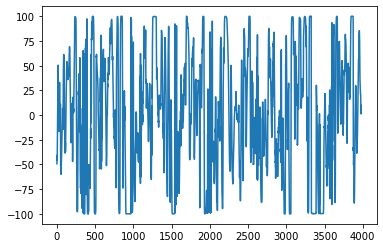

In [30]:
plt.plot(actions[-1])


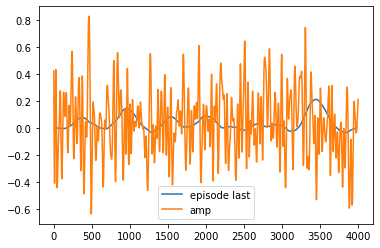

In [33]:
plt.plot(values[-1][0][0],label='episode last')
plt.plot(env.amplitude,label="amp")
plt.legend()
plt.show()

In [34]:
del policy

In [35]:
 def policy(state):
    sampled_actions = tf.squeeze(actor_model(state))
    sampled_actions = sampled_actions.numpy()  
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


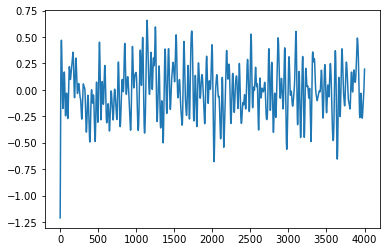

In [43]:
env.reset()
plt.plot(env.amplitude)

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 0 * Reward is ==> -16189.054195774537
Episode * 0 * J_value is ==> 1836.638905115007
[1932.66537349] [1482.24797511]


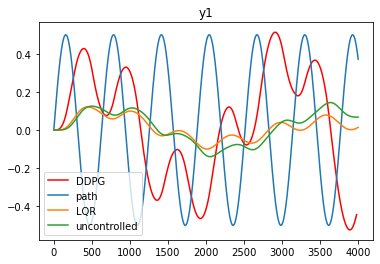

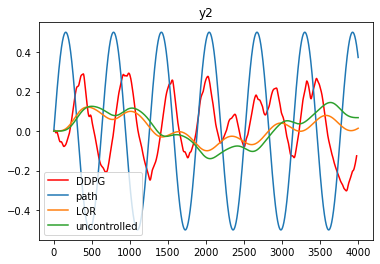

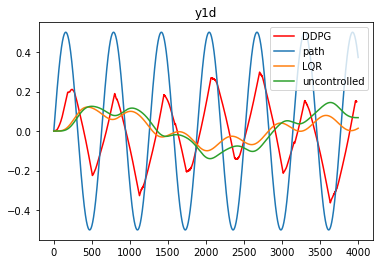

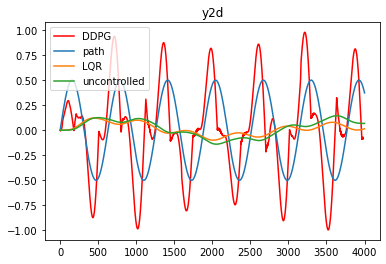

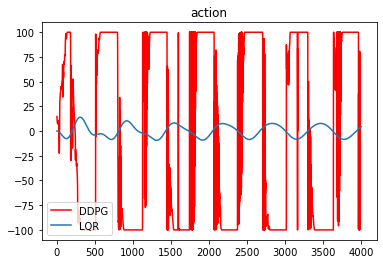

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 1 * Reward is ==> -141072.5287294595
Episode * 1 * J_value is ==> 15993.385970021864
[355278.00285061] [81167.19340064]


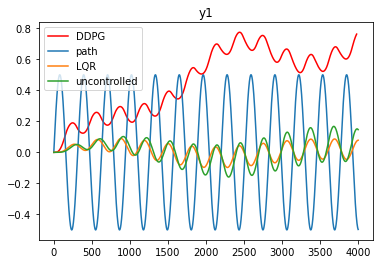

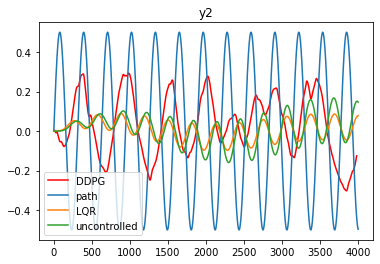

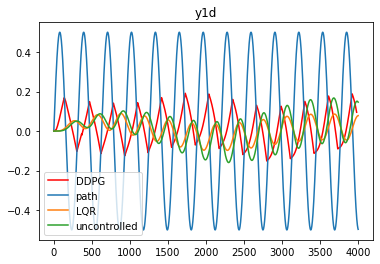

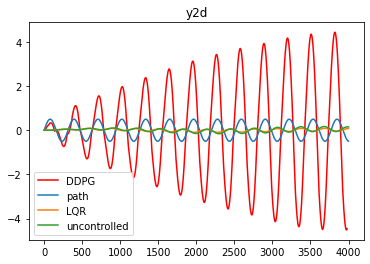

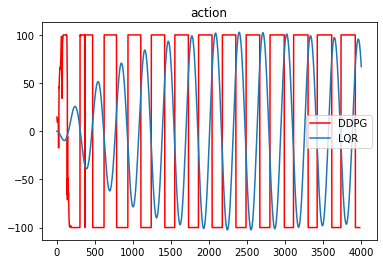

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 2 * Reward is ==> -1209.888476021169
Episode * 2 * J_value is ==> 139.95872040235218
[4579.43989228] [2267.99088354]


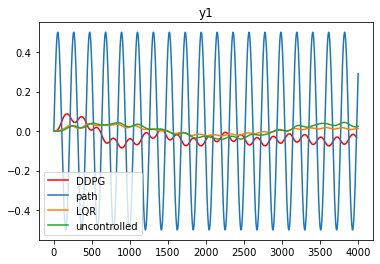

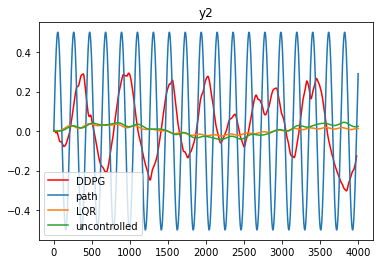

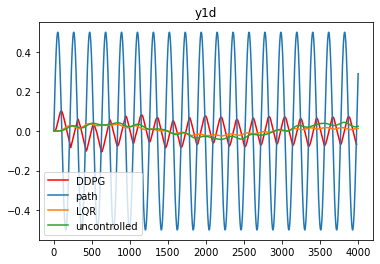

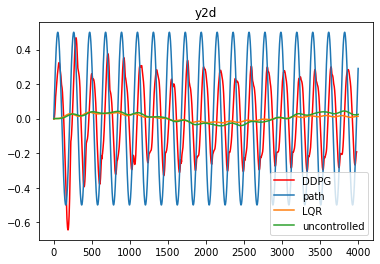

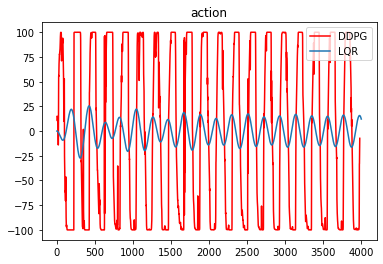

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 3 * Reward is ==> -970.866830036258
Episode * 3 * J_value is ==> 111.15816014480639
[1160.58225138] [560.93397823]


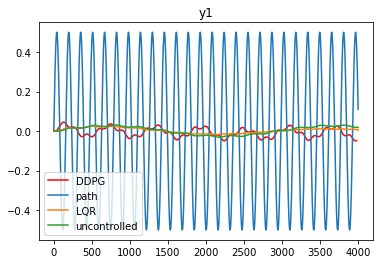

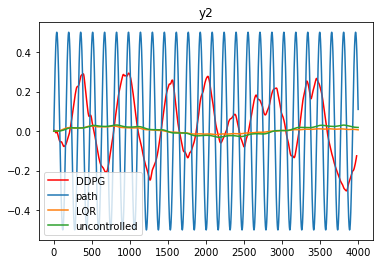

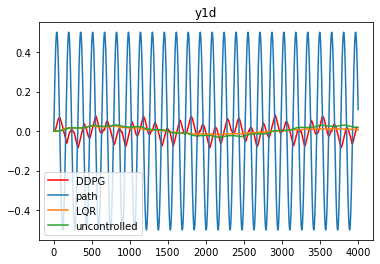

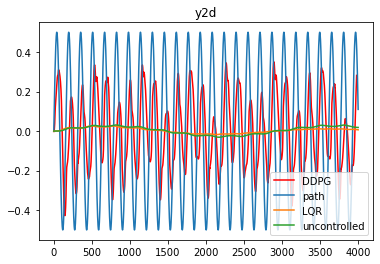

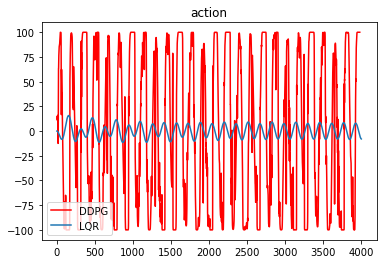

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 4 * Reward is ==> -997.0199723595468
Episode * 4 * J_value is ==> 113.01327014408814
[559.47790629] [260.64595677]


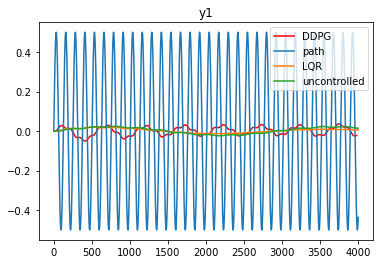

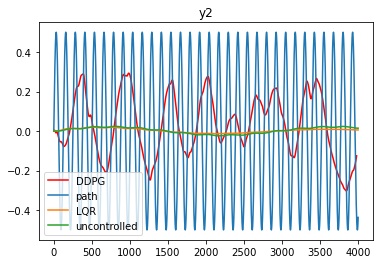

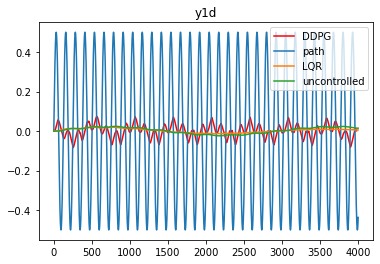

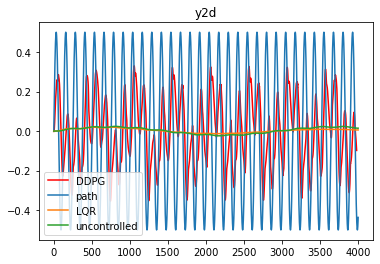

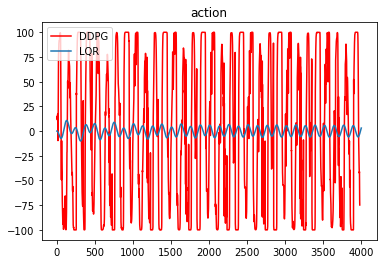

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 5 * Reward is ==> -1134.0840841409852
Episode * 5 * J_value is ==> 126.83344778765043
[339.41114327] [154.15134819]


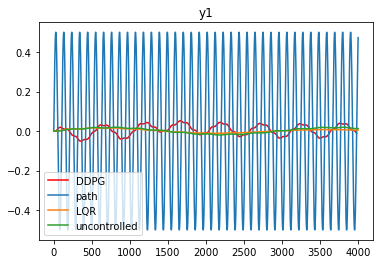

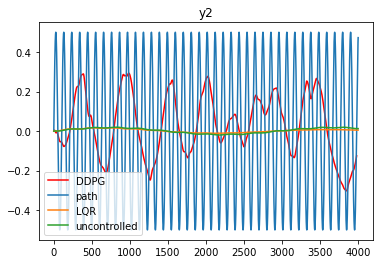

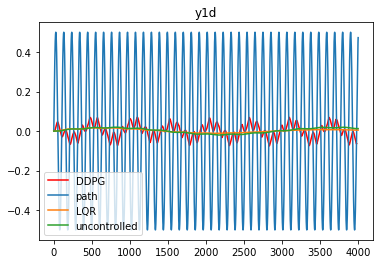

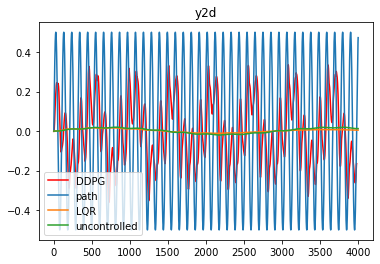

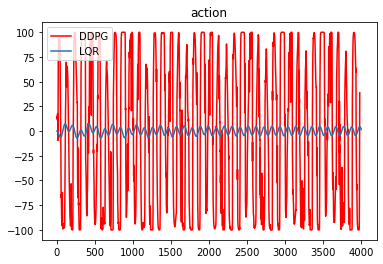

In [58]:
ep_reward = []
avg_reward = []
r = 0
rewa = []
J_vals = []
act = []
j = 0
vals = []
k = 0
A =np.array([[0 ,0 ,1 ,0 ],
              [0 ,0 ,0 ,1 ],
              [-Ks/M, Ks/M, 0, 0],
              [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
# Input matrix (Control force and Earthquake input)
B  = np.array([[0,0,1/M,-1/m]]).T
# Influence vector (Earthquake input)
E = np.array([[0,0,0,Kt/m]]).T 
# Output matrix (Disp + Accel)
Cd = np.array([[1, 1, 0, 0], [-Ks/M, Ks/M, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
Dd = np.array([[0, 1/M, -1/m]]).T
Ed = np.array([[0, 0, 0]]).T
Qp = np.array([[Ks, -Ks, 0, 0],
               [-Ks, Ks+Kt, 0, 0],
               [0, 0, M, 0],
               [0, 0, 0, m]])
# print(Qp)
(i,j)=B.shape
Rp =  (10**(0))*np.identity(j)
Kp1, Sp1, ep1 = ct.lqr(A, B, Qp, Rp)
del i, j

T = 40
dt = 0.01

nt = len(env.t)
x_uc = np.zeros([nt, 2*n, 6])
y_uc = np.zeros([nt, n, 6])
x_c = np.zeros([nt, 2*n, 6])
y_c = np.zeros([nt, n, 6])
J1_val = np.zeros([6, 1])
J2_val = np.zeros([6, 1])
U = np.zeros([nt, 6])
for ep in range(6):
    prev_state = env.reset()
    env.amplitude = 0.5*(np.sin((ep+1)*env.t))
    episodic_reward = 0
    vals.append([])
    #print("omega1: ",env.omega1, "omega2: ",env.omega2/10)
    for time in range(0,len(env.t)-20):
        env.time_current = time
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state)
        state, reward, done, info = env.step(action)
         
        episodic_reward += reward
         
        prev_state = state

    ep_reward.append(episodic_reward)
    J_vals.append(env.J_val)
    act.append(env.en) 
    vals[ep].append(env.values)
    #avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
    print("Episode * {} * J_value is ==> {}".format(ep, env.J_val))
   
    amplitude = env.amplitude
    t = env.t
    sys_uc = signal.StateSpace(A, E, Cd, np.array([[0, 0, 0]]).T)
    t1,y1,x1 = signal.lsim(sys_uc,amplitude,t)
    x_uc[:, :, k] = x1
    y_uc[:, :, k] = y1[:, 1:3]
    del t1, y1, x1

    sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, np.array([[0, 0, 0]]).T)
    t2,y2,x2 = signal.lsim(sys_c,amplitude,t)
    x_c[:, :, k] = x2
    y_c[:, :, k] = y2[:, 1:3]
    del t2, y2, x2
    for tkk in range(0,len(t)):
        U[tkk, k] = Kp1@x_c[tkk,:,k].T
        En1 = 0.5*((x_uc[tkk,:,k]@Qp)@x_uc[tkk,:,k].T)
        En2 = 0.5*((x_c[tkk,:,k]@Qp)@x_c[tkk,:,k].T)
        J1 = dt*En1
        J2 = dt*En2
        J1_val[k] += J1 
        J2_val[k] += J2
    print(J1_val[k], J2_val[k])
    k = k+1
    plt.figure()
    plt.plot(vals[-1][0][0],'r',label='DDPG')
    plt.plot(env.amplitude,label="path")
    plt.plot(x_c[:,0,k-1] ,label = "LQR")
    plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    plt.legend()
    plt.title('y1')
    plt.show()
    plt.figure()
    plt.plot(values[-1][0][1],'r',label='DDPG')
    plt.plot(env.amplitude,label="path")
    plt.plot(x_c[:,0,k-1] ,label = "LQR")
    plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    
    plt.legend()
    plt.title('y2')
    plt.show()
    plt.figure()
    plt.plot(vals[-1][0][2],'r',label='DDPG')
    plt.plot(env.amplitude,label="path")
    plt.plot(x_c[:,0,k-1] ,label = "LQR")
    plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    
    plt.legend()
    plt.title('y1d')
    plt.show()
    plt.figure()
    plt.plot(vals[-1][0][3],'r',label='DDPG')
    plt.plot(env.amplitude,label="path")
    plt.plot(x_c[:,0,k-1] ,label = "LQR")
    plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    
    plt.legend()
    plt.title('y2d')
    plt.show()
    plt.figure()
    plt.plot(act[-1],'r',label='DDPG')
    plt.plot(U[:, k-1] ,label = "LQR")
    
    plt.legend()
    plt.title('action')
    plt.show()



 
    
    


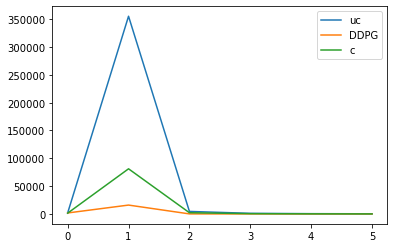

In [59]:
plt.figure()
plt.plot(J1_val,label="uc")
plt.plot(J_vals,label="DDPG")
plt.plot(J2_val,label="c")
plt.legend()
plt.show()

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 0 * Reward is ==> -2565.536037537198
Episode * 0 * J_value is ==> 289.2268342864297
[7782.7031303] [1467.67144813]


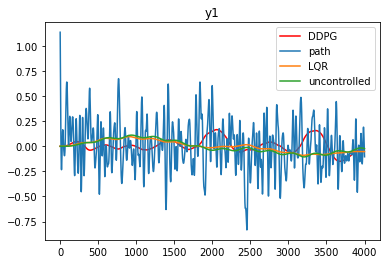

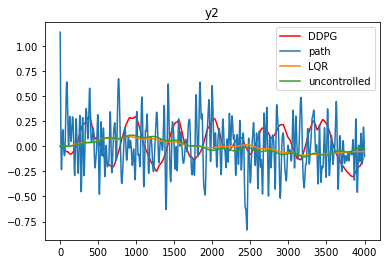

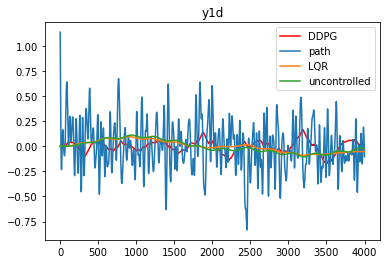

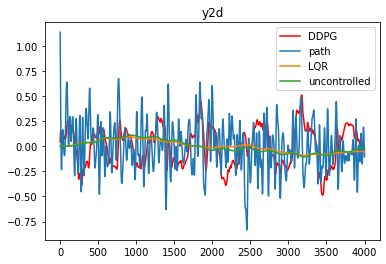

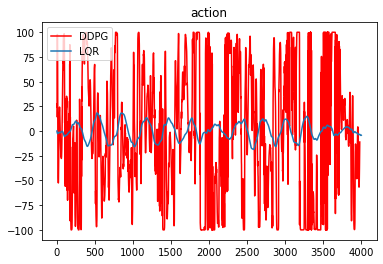

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 1 * Reward is ==> -2198.630401341583
Episode * 1 * J_value is ==> 246.85923989604487
[3469.29324872] [807.07513267]


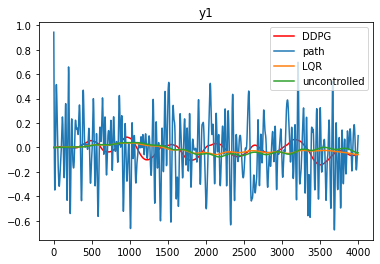

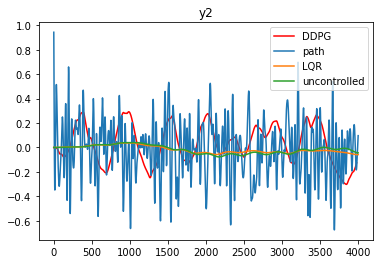

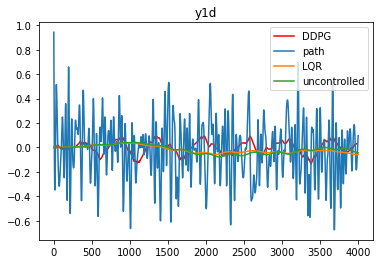

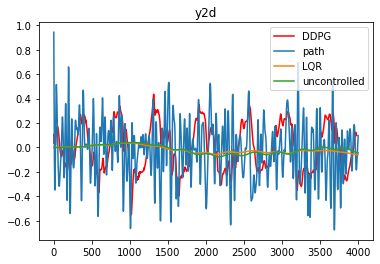

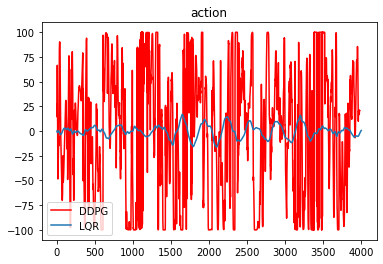

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 2 * Reward is ==> -2288.5302339144205
Episode * 2 * J_value is ==> 258.261710390327
[2440.53405306] [710.39788364]


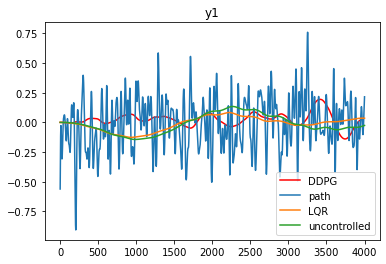

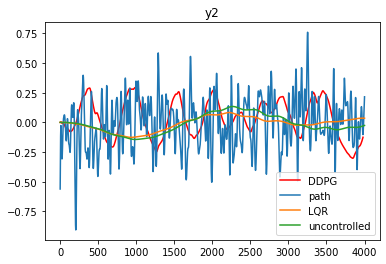

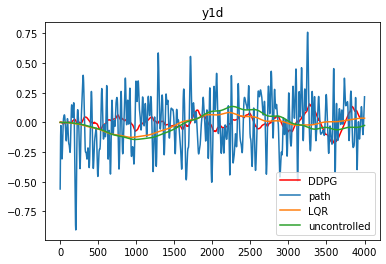

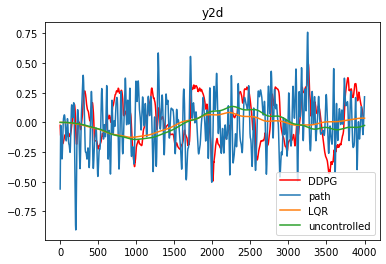

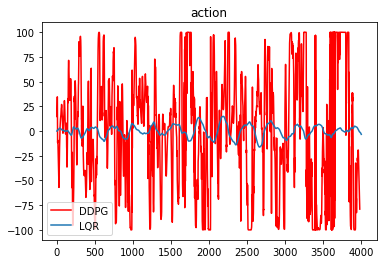

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 3 * Reward is ==> -1840.7055562270184
Episode * 3 * J_value is ==> 207.24806204724882
[3953.64666802] [2238.29925158]


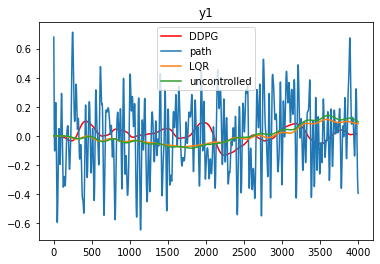

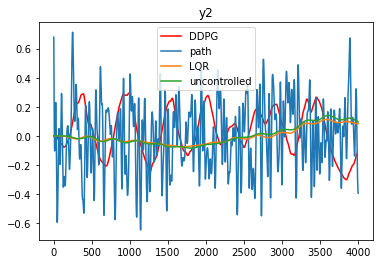

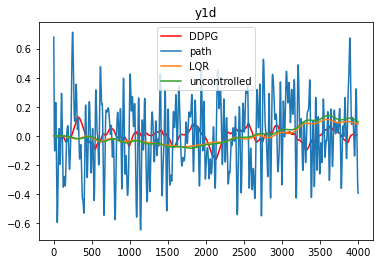

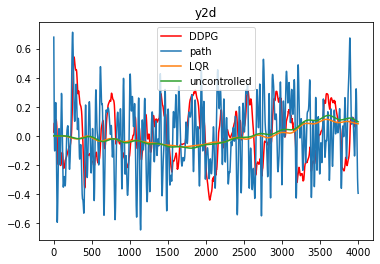

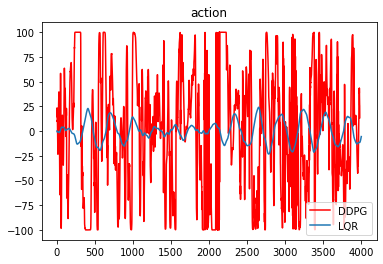

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 4 * Reward is ==> -2926.3829483871154
Episode * 4 * J_value is ==> 329.531820681901
[12473.00000051] [1909.27734295]


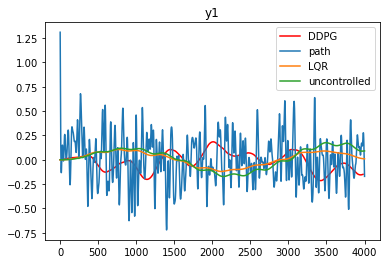

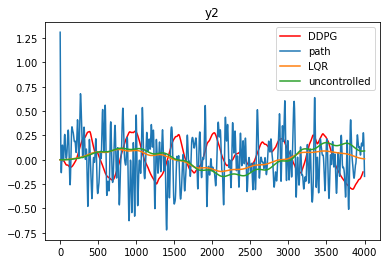

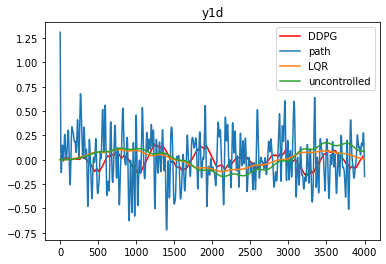

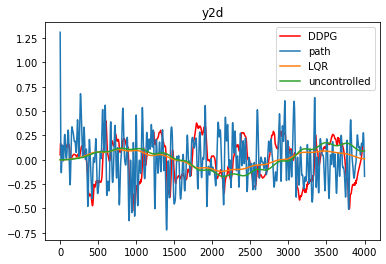

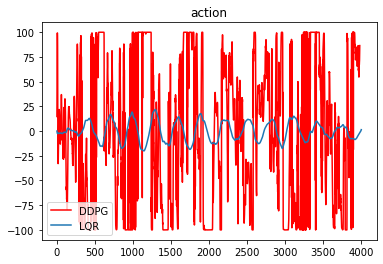

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 5 * Reward is ==> -3447.9713490932145
Episode * 5 * J_value is ==> 387.40480889639383
[1686.3992589] [814.63505924]


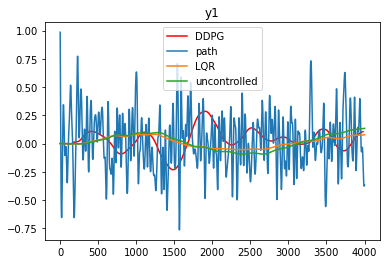

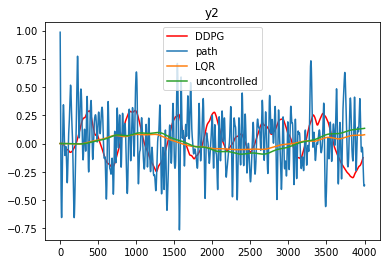

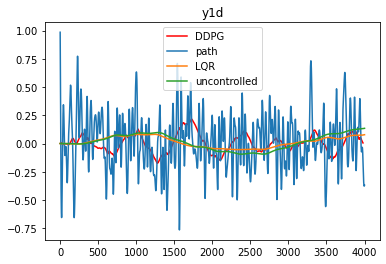

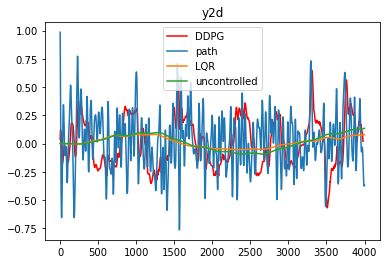

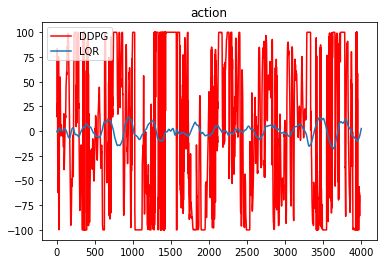

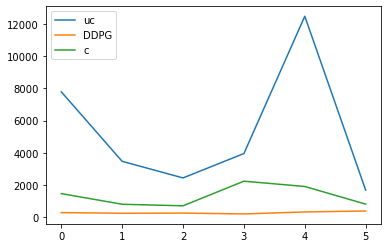

In [57]:
 ep_reward = []
avg_reward = []
r = 0
rewa = []
J_vals = []
act = []
j = 0
vals = []
k = 0
A =np.array([[0 ,0 ,1 ,0 ],
              [0 ,0 ,0 ,1 ],
              [-Ks/M, Ks/M, 0, 0],
              [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
# Input matrix (Control force and Earthquake input)
B  = np.array([[0,0,1/M,-1/m]]).T
# Influence vector (Earthquake input)
E = np.array([[0,0,0,Kt/m]]).T 
# Output matrix (Disp + Accel)
Cd = np.array([[1, 1, 0, 0], [-Ks/M, Ks/M, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
Dd = np.array([[0, 1/M, -1/m]]).T
Ed = np.array([[0, 0, 0]]).T
Qp = np.array([[Ks, -Ks, 0, 0],
               [-Ks, Ks+Kt, 0, 0],
               [0, 0, M, 0],
               [0, 0, 0, m]])
# print(Qp)
(i,j)=B.shape
Rp =  (10**(0))*np.identity(j)
Kp1, Sp1, ep1 = ct.lqr(A, B, Qp, Rp)
del i, j

T = 40
dt = 0.01

nt = len(env.t)
x_uc = np.zeros([nt, 2*n, 6])
y_uc = np.zeros([nt, n, 6])
x_c = np.zeros([nt, 2*n, 6])
y_c = np.zeros([nt, n, 6])
J1_val = np.zeros([6, 1])
J2_val = np.zeros([6, 1])
U = np.zeros([nt, 6])
for ep in range(6):
    prev_state = env.reset()
    episodic_reward = 0
    vals.append([])
    #print("omega1: ",env.omega1, "omega2: ",env.omega2/10)
    for time in range(0,len(env.t)-20):
        env.time_current = time
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state)
        state, reward, done, info = env.step(action)
         
        episodic_reward += reward
         
        prev_state = state

    ep_reward.append(episodic_reward)
    J_vals.append(env.J_val)
    act.append(env.en) 
    vals[ep].append(env.values)
    #avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
    print("Episode * {} * J_value is ==> {}".format(ep, env.J_val))
   
    amplitude = env.amplitude
    t = env.t
    sys_uc = signal.StateSpace(A, E, Cd, np.array([[0, 0, 0]]).T)
    t1,y1,x1 = signal.lsim(sys_uc,amplitude,t)
    x_uc[:, :, k] = x1
    y_uc[:, :, k] = y1[:, 1:3]
    del t1, y1, x1

    sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, np.array([[0, 0, 0]]).T)
    t2,y2,x2 = signal.lsim(sys_c,amplitude,t)
    x_c[:, :, k] = x2
    y_c[:, :, k] = y2[:, 1:3]
    del t2, y2, x2
    for tkk in range(0,len(t)):
        U[tkk, k] = Kp1@x_c[tkk,:,k].T
        En1 = 0.5*((x_uc[tkk,:,k]@Qp)@x_uc[tkk,:,k].T)
        En2 = 0.5*((x_c[tkk,:,k]@Qp)@x_c[tkk,:,k].T)
        J1 = dt*En1
        J2 = dt*En2
        J1_val[k] += J1 
        J2_val[k] += J2
    print(J1_val[k], J2_val[k])
    k = k+1
    plt.figure()
    plt.plot(vals[-1][0][0],'r',label='DDPG')
    plt.plot(env.amplitude,label="path")
    plt.plot(x_c[:,0,k-1] ,label = "LQR")
    plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    plt.legend()
    plt.title('y1')
    plt.show()
    plt.figure()
    plt.plot(values[-1][0][1],'r',label='DDPG')
    plt.plot(env.amplitude,label="path")
    plt.plot(x_c[:,0,k-1] ,label = "LQR")
    plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    
    plt.legend()
    plt.title('y2')
    plt.show()
    plt.figure()
    plt.plot(vals[-1][0][2],'r',label='DDPG')
    plt.plot(env.amplitude,label="path")
    plt.plot(x_c[:,0,k-1] ,label = "LQR")
    plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    
    plt.legend()
    plt.title('y1d')
    plt.show()
    plt.figure()
    plt.plot(vals[-1][0][3],'r',label='DDPG')
    plt.plot(env.amplitude,label="path")
    plt.plot(x_c[:,0,k-1] ,label = "LQR")
    plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    
    plt.legend()
    plt.title('y2d')
    plt.show()
    plt.figure()
    plt.plot(act[-1],'r',label='DDPG')
    plt.plot(U[:, k-1] ,label = "LQR")
    
    plt.legend()
    plt.title('action')
    plt.show()
    
plt.figure()
plt.plot(J1_val,label="uc")
plt.plot(J_vals,label="DDPG")
plt.plot(J2_val,label="c")
plt.legend()
plt.show()

In [ ]:
plt.plot(x_uc[:,0], 'r', label='Open Loop')
plt.plot(x_c[:,0], 'b', label='Optimal control')
plt.plot(ep_State_list[:,0,0],label='episode 0')
plt.plot(ep_State_list[:,0,499], label='episode 499')

plt.legend()
plt.show()

In [ ]:
plt.plot(x_uc[:,1], 'r', label='Open Loop')
plt.plot(x_c[:,1], 'b', label='Optimal control')
plt.plot(ep_State_list[:,1,0],label='episode 0')
plt.plot(ep_State_list[:,1,499], label='episode 499')

plt.legend()
plt.show()

In [ ]:
plt.plot(x_uc[:,2], 'r', label='Open Loop')
plt.plot(x_c[:,2], 'b', label='Optimal control')
plt.plot(ep_State_list[:,2,0],label='episode 0')
plt.plot(ep_State_list[:,2,499], label='episode 499')

plt.legend()
plt.show()

In [ ]:
plt.plot(x_uc[:,3], 'r', label='Open Loop')
plt.plot(x_c[:,3], 'b', label='Optimal control')
plt.plot(ep_State_list[:,3,0],label='episode 0')
plt.plot(ep_State_list[:,3,499], label='episode 499')

plt.legend()
plt.show()

In [ ]:
plt.plot(ep_reward_list)


In [ ]:

plt.plot(values[30][0][0],label='episode 100')
plt.plot(values[99][0][0],label='episode ')
 
plt.legend()
plt.show()

In [ ]:
plt.plot(env.hr)

In [ ]:
plt.plot(J_values)

In [ ]:
plt.plot(ep_reward_list)


In [ ]:
plt.plot(actions[149])

In [ ]:
plt.plot(actions[145])

In [ ]:
plt.plot(actions[141])

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 0 * Reward is ==> -16967.03769560118
Episode * 0 * J_value is ==> 1930.9580211430173
[1932.66537349]


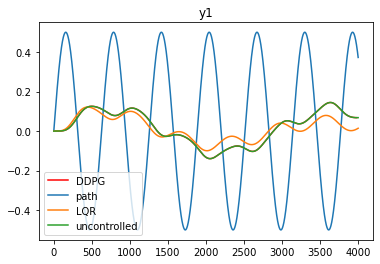

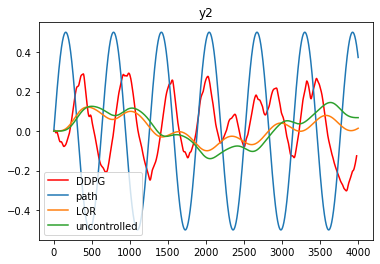

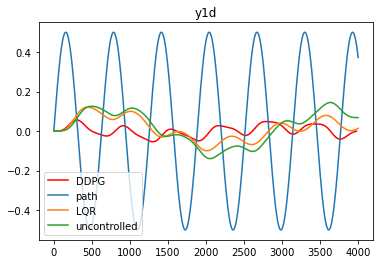

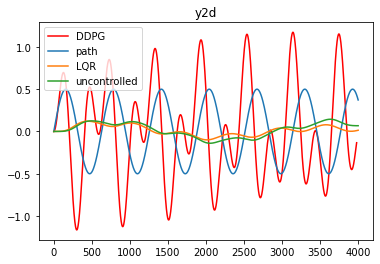

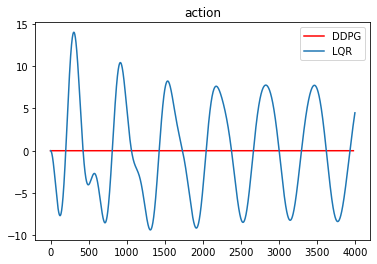

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 1 * Reward is ==> -3105722.279522457
Episode * 1 * J_value is ==> 352741.27936870465
[355278.00285061]


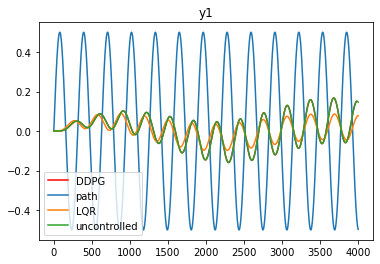

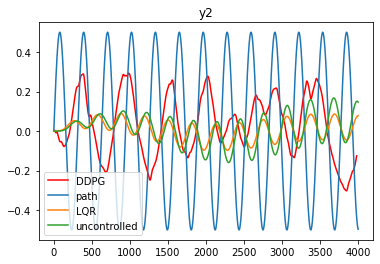

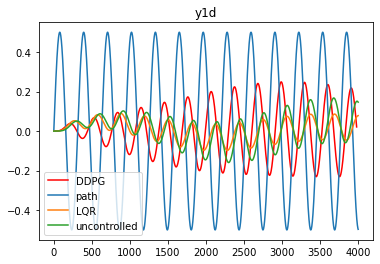

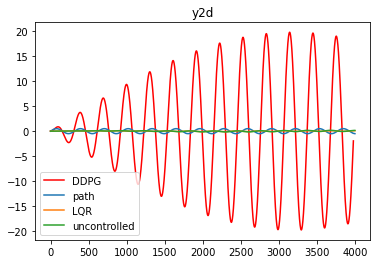

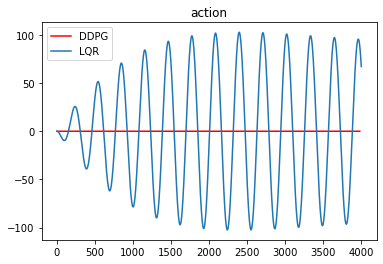

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 2 * Reward is ==> -40052.03093711025
Episode * 2 * J_value is ==> 4549.669204266506
[4579.43989228]


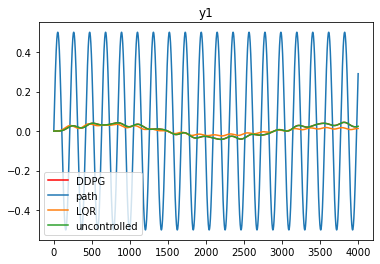

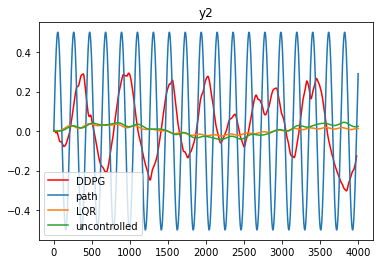

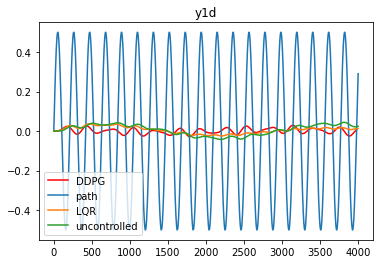

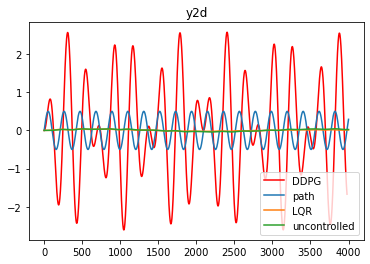

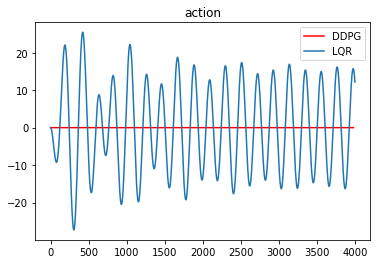

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 3 * Reward is ==> -10186.230467057596
Episode * 3 * J_value is ==> 1159.1546436431802
[1160.58225138]


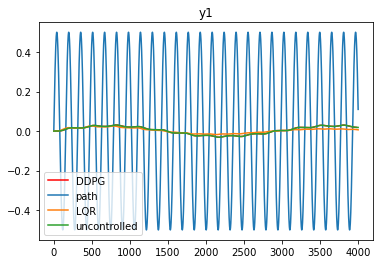

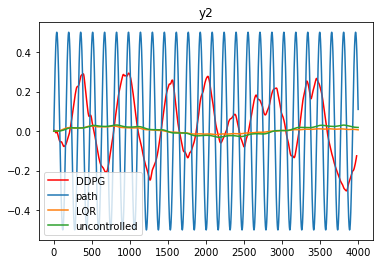

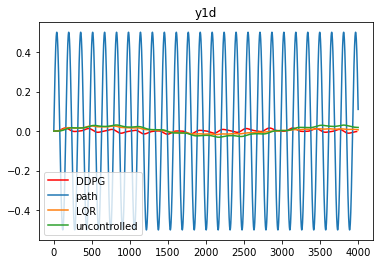

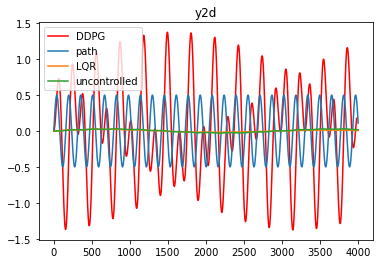

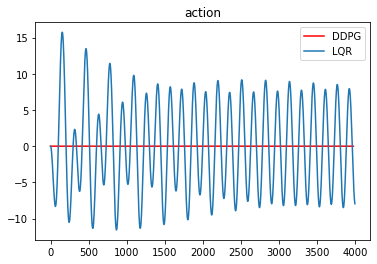

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 4 * Reward is ==> -4893.732188070612
Episode * 4 * J_value is ==> 556.0788040801124
[559.47790629]


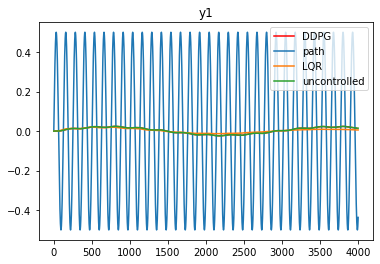

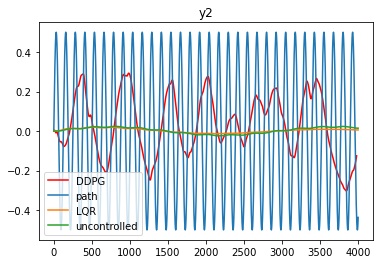

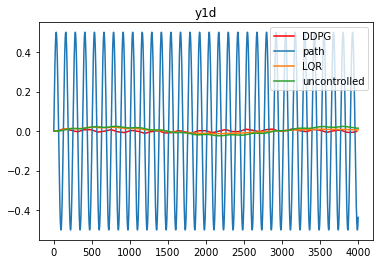

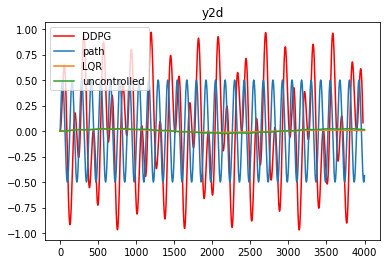

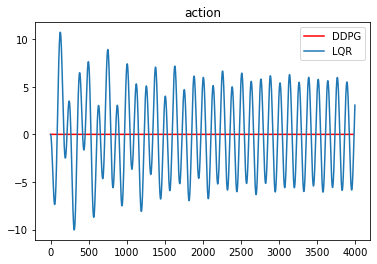

/home/user/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode * 5 * Reward is ==> -2971.113953487632
Episode * 5 * J_value is ==> 337.472941441331
[339.41114327]


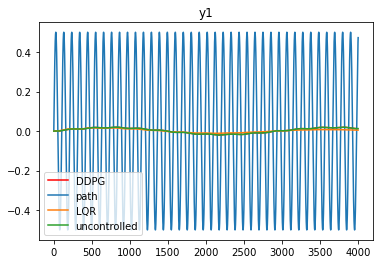

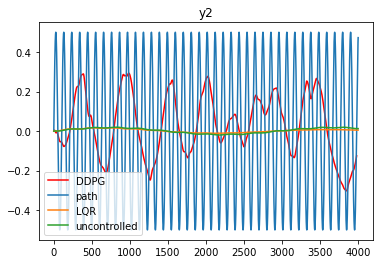

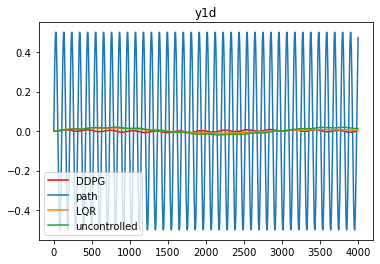

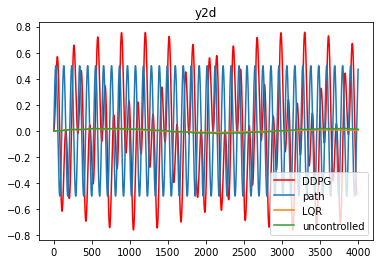

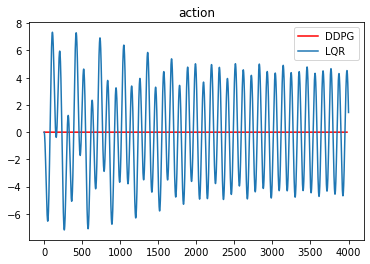

In [60]:
ep_reward = []
avg_reward = []
r = 0
rewa = []
J_vals = []
act = []
j = 0
vals = []
k = 0
A =np.array([[0 ,0 ,1 ,0 ],
              [0 ,0 ,0 ,1 ],
              [-Ks/M, Ks/M, 0, 0],
              [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
# Input matrix (Control force and Earthquake input)
B  = np.array([[0,0,1/M,-1/m]]).T
# Influence vector (Earthquake input)
E = np.array([[0,0,0,Kt/m]]).T 
# Output matrix (Disp + Accel)
Cd = np.array([[1, 1, 0, 0], [-Ks/M, Ks/M, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
Dd = np.array([[0, 1/M, -1/m]]).T
Ed = np.array([[0, 0, 0]]).T
Qp = np.array([[Ks, -Ks, 0, 0],
               [-Ks, Ks+Kt, 0, 0],
               [0, 0, M, 0],
               [0, 0, 0, m]])
# print(Qp)
(i,j)=B.shape
Rp =  (10**(0))*np.identity(j)
Kp1, Sp1, ep1 = ct.lqr(A, B, Qp, Rp)
del i, j

T = 40
dt = 0.01

nt = len(env.t)
x_uc = np.zeros([nt, 2*n, 6])
y_uc = np.zeros([nt, n, 6])
x_c = np.zeros([nt, 2*n, 6])
y_c = np.zeros([nt, n, 6])
J1_val = np.zeros([6, 1])
J2_val = np.zeros([6, 1])
U = np.zeros([nt, 6])
for ep in range(6):
    prev_state = env.reset()
    env.amplitude = 0.5*(np.sin((ep+1)*env.t))
    episodic_reward = 0
    vals.append([])
    #print("omega1: ",env.omega1, "omega2: ",env.omega2/10)
    for time in range(0,len(env.t)-20):
        env.time_current = time
        state, reward, done, info = env.step(0)
        episodic_reward += reward
        prev_state = state

    ep_reward.append(episodic_reward)
    J_vals.append(env.J_val)
    act.append(env.en) 
    vals[ep].append(env.values)
    #avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
    print("Episode * {} * J_value is ==> {}".format(ep, env.J_val))
   
    amplitude = env.amplitude
    t = env.t
    sys_uc = signal.StateSpace(A, E, Cd, np.array([[0, 0, 0]]).T)
    t1,y1,x1 = signal.lsim(sys_uc,amplitude,t)
    x_uc[:, :, k] = x1
    y_uc[:, :, k] = y1[:, 1:3]
    del t1, y1, x1

    sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, np.array([[0, 0, 0]]).T)
    t2,y2,x2 = signal.lsim(sys_c,amplitude,t)
    x_c[:, :, k] = x2
    y_c[:, :, k] = y2[:, 1:3]
    del t2, y2, x2
    for tkk in range(0,len(t)):
        U[tkk, k] = Kp1@x_c[tkk,:,k].T
        En1 = 0.5*((x_uc[tkk,:,k]@Qp)@x_uc[tkk,:,k].T)
        En2 = 0.5*((x_c[tkk,:,k]@Qp)@x_c[tkk,:,k].T)
        J1 = dt*En1
        J2 = dt*En2
        J1_val[k] += J1 
        J2_val[k] += J2
    print(J1_val[k])
    k = k+1
    plt.figure()
    plt.plot(vals[-1][0][0],'r',label='DDPG')
    plt.plot(env.amplitude,label="path")
    plt.plot(x_c[:,0,k-1] ,label = "LQR")
    plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    plt.legend()
    plt.title('y1')
    plt.show()
    plt.figure()
    plt.plot(values[-1][0][1],'r',label='DDPG')
    plt.plot(env.amplitude,label="path")
    plt.plot(x_c[:,0,k-1] ,label = "LQR")
    plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    
    plt.legend()
    plt.title('y2')
    plt.show()
    plt.figure()
    plt.plot(vals[-1][0][2],'r',label='DDPG')
    plt.plot(env.amplitude,label="path")
    plt.plot(x_c[:,0,k-1] ,label = "LQR")
    plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    
    plt.legend()
    plt.title('y1d')
    plt.show()
    plt.figure()
    plt.plot(vals[-1][0][3],'r',label='DDPG')
    plt.plot(env.amplitude,label="path")
    plt.plot(x_c[:,0,k-1] ,label = "LQR")
    plt.plot(x_uc[:,0,k-1] ,label = "uncontrolled")
    
    plt.legend()
    plt.title('y2d')
    plt.show()
    plt.figure()
    plt.plot(act[-1],'r',label='DDPG')
    plt.plot(U[:, k-1] ,label = "LQR")
    
    plt.legend()
    plt.title('action')
    plt.show()



 
    
    


In [61]:
print(J1_val)
print(J2_val)

[[1.93266537e+03]
 [3.55278003e+05]
 [4.57943989e+03]
 [1.16058225e+03]
 [5.59477906e+02]
 [3.39411143e+02]]
[[ 1482.24797511]
 [81167.19340064]
 [ 2267.99088354]
 [  560.93397823]
 [  260.64595677]
 [  154.15134819]]


In [67]:
T = 40
dt = 0.01
t = np.arange(0, T+dt, dt)
nt = len(t)
x_uc = np.zeros([nt, 2*n, 6])
y_uc = np.zeros([nt, n, 6])
x_c = np.zeros([nt, 2*n, 6])
y_c = np.zeros([nt, n, 6])
J1_val = np.zeros([6, 1])
J2_val = np.zeros([6, 1])
U = np.zeros([nt, 6])


# Input Sinusoid (Resonant Frequencies)
k = 0
for i in range(1, 3):
    for j in range(0, 3):
        omega1 = i
        omega2 = j/10
        amplitude = (np.sin(omega1*t) + np.sin(omega2*t))
        prev_state = env.reset()
        env.amplitude = amplitude
        episodic_reward = 0
        #print("omega1: ",env.omega1, "omega2: ",env.omega2/10)
        for time in range(0,len(env.t)-20):
            env.time_current = time
            state, reward, done, info = env.step(0)
            episodic_reward += reward
            prev_state = state
        #avg_reward = np.mean(ep_reward_list[-40:])
        #print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
        print("Episode * {} * J_value is ==> {}".format(ep, env.J_val))
        
        
        # Openloop
        sys_uc = signal.StateSpace(A, E, Cd, np.array([[0, 0, 0]]).T)
        t1,y1,x1 = signal.lsim(sys_uc,amplitude,t)
        x_uc[:, :, k] = x1
        y_uc[:, :, k] = y1[:, 1:3]
        del t1, y1, x1

        sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, np.array([[0, 0, 0]]).T)
        t2,y2,x2 = signal.lsim(sys_c,amplitude,t)
        x_c[:, :, k] = x2
        y_c[:, :, k] = y2[:, 1:3]
        del t2, y2, x2
        k = k+1
del i, j, k
for k in range(0, 6):
    for tkk in range(0,len(t)):
        U[tkk, k] = Kp1@x_uc[tkk,:,k].T
        En1 = 0.5*((x_uc[tkk,:,k]@Qp)@x_uc[tkk,:,k].T)
        En2 = 0.5*((x_c[tkk,:,k]@Qp)@x_c[tkk,:,k].T)
        J1 = dt*En1
        J2 = dt*En2
        J1_val[k] += J1 
        J2_val[k] += J2
print(J1_val)

Episode * 5 * J_value is ==> 7723.832084572069
Episode * 5 * J_value is ==> 10957.371114684805
Episode * 5 * J_value is ==> 14536.907347173945
Episode * 5 * J_value is ==> 1410965.1174748186
Episode * 5 * J_value is ==> 1420417.1785713143
Episode * 5 * J_value is ==> 1430186.6930603595
[[   7730.66149397]
 [  10964.3944059 ]
 [  14641.84077091]
 [1421112.01140244]
 [1431401.70678702]
 [1439467.14511079]]
